# Using Census Data to Predict Adult Incomes

<b>Research Question:</b> The objective of this analysis is to determine whether demographic and economic data extracted from the 1996 U.S. census can be utilized to predict which individuals earn an annual income exceeding $50,000. This investigation seeks to identify key predictors of income level, with the hope of enabling targeted economic interventions and improved socio-economic planning.

<b>Data:</b> The dataset for this research is sourced from Kaggle.com, originally extracted from the 1996 Census Bureau Database by Ronny Kohavi and Barry Becker. It comprises detailed demographic data of individuals aged 16 and above, each with an Adjusted Gross Income (AGI) of at least $100. This dataset includes a variety of attributes such as age, education, occupation, and hours worked per week, making it an ideal source for predictive modeling.

(Kohavi, R., & Becker, B. (1996). Adult Census Income. Kaggle. https://www.kaggle.com/uciml/adult-census-income)

<b>Methodology</b>: This study will employ three binary classification models to predict whether individuals earn more than $50,000 per year. The models to be compared are:

-  Logistic Regression
-  Random Forest
-  Gradient Boosting

Each model's performance will be evaluated through a series of metrics such as accuracy, precision, recall, F1-score, and ROC-AUC curves to determine their effectiveness in predicting high income earners. Comparisons will be made to determine which model most accurately predicts the target variable.

The outcome of this comparative analysis will provide insights into the predictive power of census data concerning individual income levels, with the ultimate aim to contribute valuable information for policymakers and economists focused on income inequality and economic stability.

In [1]:
#=================================================-
#### Loading packages  ####

# Silence all warnings 
import warnings
warnings.filterwarnings('ignore')

# Helper packages.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap


# Scikit-learn package for logistic regression.
from sklearn import linear_model

# Model set up and tuning packages from scikit-learn.
from sklearn.model_selection import train_test_split

# Scikit-learn packages for evaluating model performance.
from sklearn import metrics

# Scikit-learn package for data preprocessing.
from sklearn import preprocessing

# Random forests and boosting packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

### Data Preparation & EDA

To begin our analysis, we will first import the dataset and conduct a preliminary exploration to understand its structure and key characteristics. This step includes examining variable types, checking for completeness, and summarizing the data with descriptive statistics. This foundational knowledge will guide our data preprocessing and analytical approaches.

In [2]:
#=================================================-
#### Loading data into Python  ####

census = pd.read_csv("/Users/warrenasfazadour/desktop/Intro_to_ML_Sup/data/adult.csv")
print(census.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


The dataset comprises 32,561 individual observations, each characterized by 15 features.


The following is a summary of the features (6 numeric, 9 categorical) in the data:

<b>Numeric Features</b>:

1. age: Represents the age of individuals.
2. fnlwgt: Final weight of individuals, possibly related to the number of people the census believes the entry represents. 
3. education.num: A numerical representation of education level.
4. capital.gain: Possibly income from investment sources other than salary/wages. 
5. capital.loss: Possibly losses from investment sources other than salary/wages. 
6. hours.per.week: Number of hours worked per week.

<b>Categorical Features</b>:

7. workclass: The work sector of the individual (e.g., Private, Self-emp, Government). 
8. education: Highest level of education achieved (e.g., Bachelors, Masters).
9. marital.status: Marital status (e.g., Married, Never-married).
10. occupation: Job (e.g., Tech-support, Craft-repair). 
11. relationship: Family relationship (e.g., Wife, Own-child).
12. race: Race of individual (e.g., White, Black). 
13. sex: Gender (Male or Female). 
14. native.country: Country of origin (e.g., United States, Mexico).
15. income: Income level, split into binary categories >50K and <=50K. 

We will address the transformation of some categorical variables into dummy variables in subsequent analyses. For now, we will focus on examining the class balance of our target variable. This step is essential for determining the distribution of labels across the dataset, a factor that critically impacts the performance of the predictive models we intend to develop.

In [3]:
#=================================================-
#### Frequency table of the target variable & total Observations  ####

print(census['income'].value_counts())

<=50K    24720
>50K      7841
Name: income, dtype: int64


The target variable in our dataset exhibits an imbalance, as individuals earning above $50K constitute only 24% of the observations. This distribution reflects the well-known demographic reality that higher earners represent a minority in the United States. Given the extent of this imbalance, we could run into an issue where our model will have a hard time predicting the minority class. If this arises we will consider employing Synthetic Minority Over-sampling Technique (SMOTE) to address this issue. SMOTE is a method for generating synthetic samples from the minority class, thus enhancing the balance of the dataset, which could potentially improve the performance of our predictive models. 

We will proceed with the data cleaning process by conducting a examination of missing values.

In [4]:
#=================================================-
#### Data prep: check for NAs  ####

## Check for NAs.
#print(census.isnull().sum())

# Replace unknown ('?') information with null
census = census.replace(to_replace='?', value=np.NaN)
print(census.isnull().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


Upon initial examination, the dataset appeared to have no missing values. However, a subsequent visual inspection revealed the presence of question marks ("?") within the data, indicating missing entries. This observation confirms that missing values do exist, specifically within the 'workclass', 'occupation', and 'native.country' features.

Before we conduct a detailed analysis of the observations within the features that contain missing values, it is important to note that all of these features are categorical. This makes the evaluation regarding their suitability for transformation into dummy variables very important. The necessity of this evaluation stems from the fact that most machine learning algorithms are designed to work with numerical input and cannot directly process categorical variables. As such, categorical features must either be converted into a numerical format through methods such as dummy variable encoding, or be removed from the analysis if they are not deemed suitable for conversion.If these categorical features are not good candidates for convertion into dummy variables we can remove them all together and do not need to handle the missing data.

In our analysis, a critical aspect we will monitor is the number of labels present in each categorical feature. This is because of the fact that each label, when transformed into a dummy variable, adds an additional dimension to the dataset. This process of converting categorical labels into individual binary features, though useful for integrating categorical data into machine learning models, can lead to a significant increase in the dataset's dimensionality.

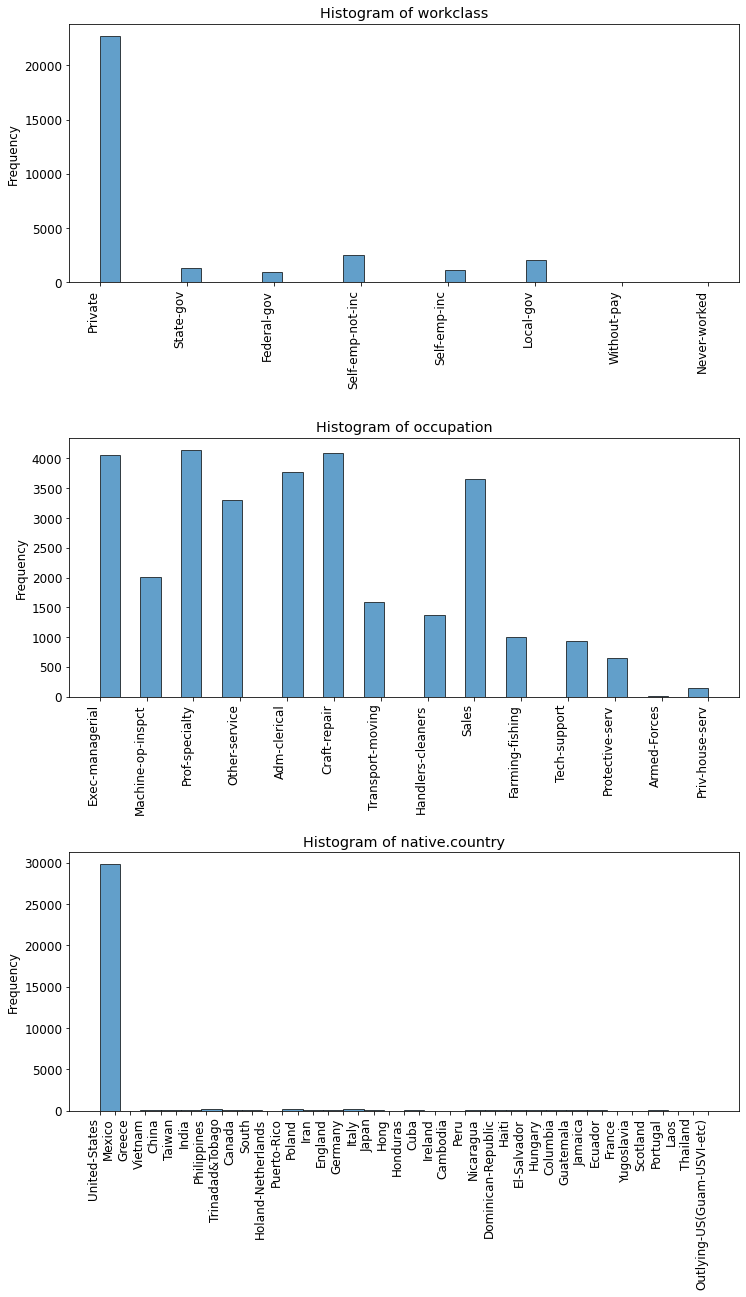

In [5]:
#=================================================-
#### Data prep: Visualize observations of features with missing values  ####

# List of features to plot
features = ['workclass', 'occupation', 'native.country']

# Increase the default font sizes globally
plt.rcParams.update({'font.size': 12})  

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 20))  # Adjust the size as needed

# Loop through the features and create a histogram for each
for ax, feature in zip(axes, features):
    ax.hist(census[feature].dropna(), bins=30, edgecolor='k', alpha=0.7)
    ax.set_title(f'Histogram of {feature}')
    ax.set_ylabel('Frequency')
    # Rotate x-axis labels
    labels = census[feature].dropna().unique().tolist()
    ax.set_xticks([i for i in range(len(labels))], labels, rotation=90, ha='right')

plt.subplots_adjust(hspace=0.6)
plt.show()

The analysis of the first histogram reveals a significant imbalance in the 'workclass' feature, and has no straightforward method to categorize certain labels to reduce dimensionality. Similarly, the 'occupation' feature exhibits an excessive number of labels, which complicates any potential grouping efforts. The 'native.country' feature also displays an imbalance; however, it is feasible to bifurcate this feature into two distinct groups: natives and non-natives of the USA. Despite this possibility, creating such a binary classification may be redundant given the presence of the 'race' feature, which likely captures similar variance.

Moreover, the presence of missing values further complicates the utility of these features. So, given the imbalance, the difficulty in reducing dimensionality, potential redundancy, and missing values, it is statistically justifiable to eliminate the 'workclass', 'occupation', and 'native.country' features from further analysis. This decision aims to enhance the model's robustness and the interpretability of the results.

We will now proceed to examine the remaining categorical variables in the dataset, excluding the 'education' variable due to its redundancy with the numeric feature 'education.num'. Not including 'education.num' ensures a more efficient analysis by avoiding the duplication of information, thereby focusing on variables that provide unique insights into the dataset.

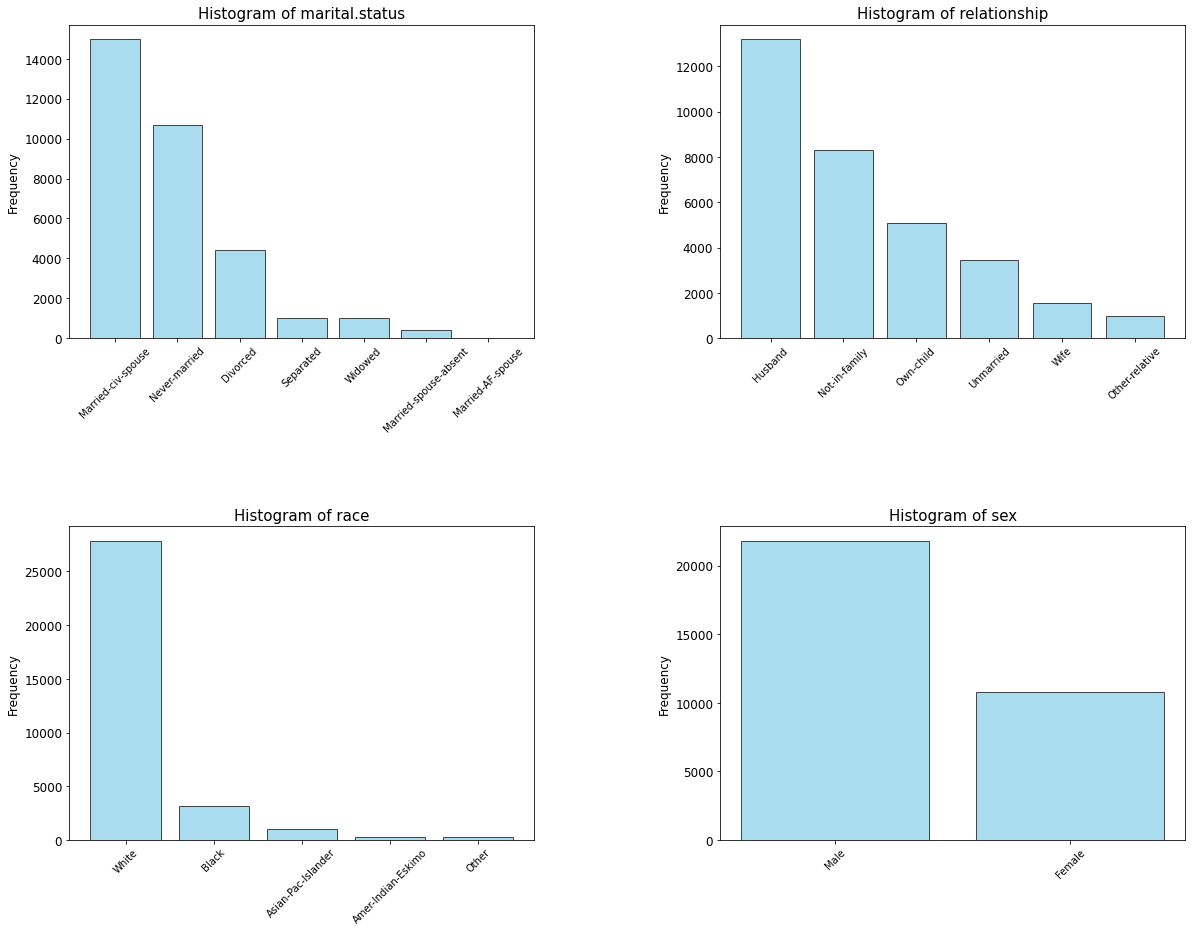

In [6]:
#=================================================-
#### Exploring with categorical variables  ####

# List of features to plot
features = ['marital.status', 'relationship', 'race', 'sex']

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15)) 
axes = axes.flatten()  # This is important to flatten the 2D array of axes into 1D

# Loop through the features and create a bar chart for each
for ax, feature in zip(axes, features):
    counts = census[feature].value_counts()
    ax.bar(counts.index, counts.values, color='skyblue', edgecolor='k', alpha=0.7)
    ax.set_title(f'Histogram of {feature}', fontsize=15)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10)  # Rotate x-axis labels for better readability

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()

In the analysis of the initial histograms, significant redundancy is evident between the "marital.status" and "relationship" features. Specifically, the overlap between the "married-civ-spouse" category in "marital.status" and the combined counts of the "husband" and "wife" categories in "relationship" (each approximating 15,000 observations) suggest duplicative information. Therefore, to streamline the dataset, the "relationship" feature will be omitted due to its redundancy.

Further, to enhance model simplicity and address the redundancy in "marital.status," the categories within this feature will be consolidated into two distinct groups: "married" and "single." This reduction not only simplifies the variable but also enhances the interpretability of the model's output without sacrificing significant information.

The "race" feature presents a significant imbalance, with "White" being the predominant category. To mitigate this skewness and reduce dimensionality, the categories will be bifurcated into "White" and "Non-White." This binary categorization strategy effectively addresses the imbalance, enabling a more generalized and robust analysis.

The "sex" feature is already binary ("Male" and "Female"), so no further modification for statistical modeling purposes is necessary.

Before proceeding with adjustments to the categorical features, it is important to conduct a detailed inspection of the numerical features in our dataset. This step is crucial to ensure that these features do not require any modifications. By thoroughly assessing the numerical data first, we can confirm their readiness for inclusion in our models without additional preprocessing or transformation. This ensures that our dataset is properly prepared and that all features are optimally configured to contribute accurately to the predictive analysis. The 'fnlwgt' attribute was omitted due to the lack of clarity regarding the specific metrics it intends to measure.

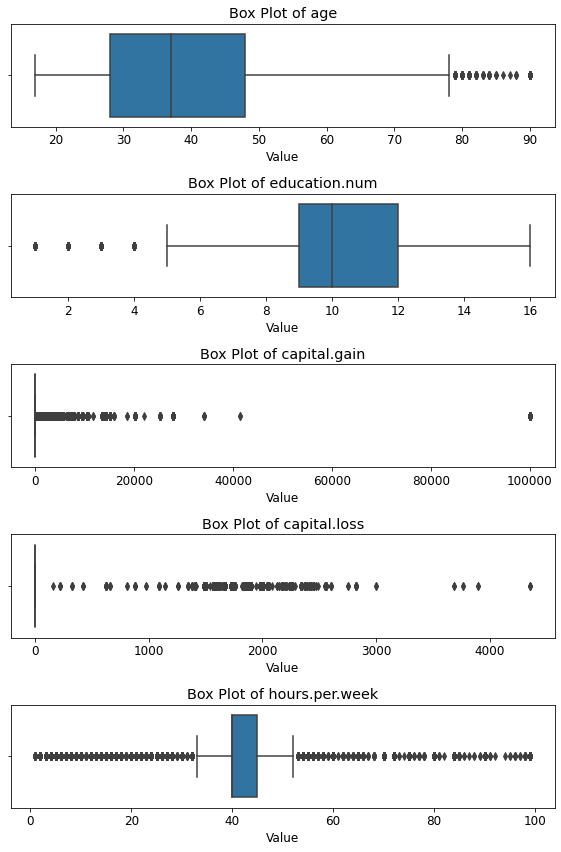

In [7]:
#=================================================-
#### Exploring with numerical variables  ####

# Create separate box plots for each feature
census_num = census.drop('fnlwgt', axis=1).select_dtypes(include=np.number)

fig, axes = plt.subplots(nrows=len(census_num.columns), ncols=1, figsize=(8, 12))

for i, column in enumerate(census_num.columns):
    sns.boxplot(x=census[column], ax=axes[i])
    axes[i].set_title(f'Box Plot of {column}')
    axes[i].set_xlabel('Value')

plt.tight_layout()
plt.show()

Upon examining the box-and-whisker plots, no significant issues are evident. Although numerous outliers are present across the plots, it is advisable to retain these in order to preserve the authentic dispersion of data that reflects the demographic diversity observed in society.

From here, we will construct a correlation matrix for our dataset to make sure there is no collinearity among the variables. Prior to this analysis, we will execute all the cleaning steps previously outlined, which include the removal of specific features and the conversion of certain variables into dummy variables.

In [8]:
#=================================================-
#### Working with categorical variables  ####

# Consolidate marital status into two categories to reduce dimensionality
census["marital.status"] = np.where((census["marital.status"] == 'Married-civ-spouse') | (census['marital.status'] == 'Married-AF-spouse'), 'Married', 'Single')

#consolidate race into two categories to reduce dimensionality
census["race"] = np.where((census["race"] == 'White'), 'White', 'non-White')

print(census['marital.status'].value_counts())
print(census['race'].value_counts())

Single     17562
Married    14999
Name: marital.status, dtype: int64
White        27816
non-White     4745
Name: race, dtype: int64


In [9]:
#=================================================-
#### Transform and replace categorical variables  ####

# Convert 'marital.status' into dummy variables.
marital_status_dummy = pd.get_dummies(census['marital.status'], drop_first = True)

# Convert 'sex' into dummy variables.
sex_dummy = pd.get_dummies(census['sex'], prefix='sex', drop_first = True)

# Convert 'race' into dummy variables.
race_dummy = pd.get_dummies(census['race'], prefix = 'race', drop_first = True)

# Drop `marital.status` `sex` and `race`from the data.
census.drop(['marital.status', 'sex', 'race'], axis = 1, inplace = True)

# Concatenate `marital.status` `sex_dummy` and `race_dummy` to our dataset.
census = pd.concat([census,marital_status_dummy,sex_dummy,race_dummy],axis=1)

#Drop other redundant features
census.drop(['fnlwgt',
             'education', 
             'relationship', 
             'workclass', 
             'occupation', 
             'native.country'], axis = 1, inplace = True)

We will now convert our dependent variable into a binary indicator to make it compatible with our models.

In [10]:
#=================================================-
#### Data prep: target  ####

print(census.income.dtypes)
census["income"] = np.where(census["income"] == '>50K', True, False)

# Check class again.
print(census.income.dtypes)
print(census['income'].sum())

object
bool
7841


Having eliminated redundant features and transformed categorical variables into dummy variables, we will now examine the correlation matrix of the remaining features. This analysis is essential to detect any colinearity, which could potentially undermine the performance of our predictive models.

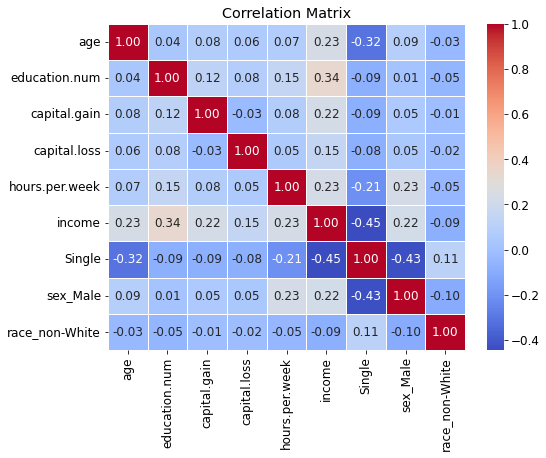

In [11]:
#=================================================-
#### Data prep: target  ####

# Calculate the correlation matrix
corr_matrix = census.corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Looking at the correlation matrix reveals no evidence of collinearity among the variables, including the dependent variable. The absence of significant correlation with the dependent variable could potentially challenge the accuracy of our classification model.

At this point, no additional data cleaning or exploratory analysis is required, so we can proceed to partition our dataset into training and testing subsets for further model evaluation.

In [12]:
#=================================================-
#### Split into train and test set  ####

# Separate predictors from data.
# We can just drop the target variable, as we are using all other variables as predictors.
X = census.drop(['income'], axis = 1)

# Separate target from data.
y = np.array(census['income'])

# Set the seed.
np.random.seed(1)

# Split data into training and test sets, use a 70 train - 30 test split.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .3)

### Modeling - Logistics Regression

We will now proceed to the training, optimization, and evaluation of our models. This phase involves fitting the models to the training data and assessing their effectiveness using statistical metrics. This approach ensures that the models are robust and yield reliable predictions.

In [13]:
#=================================================-
#### Logistic regression: build  ####

# Set up logistic regression model.
logistic_regression_model = linear_model.LogisticRegression(max_iter=1000, solver='lbfgs')
print(logistic_regression_model)

LogisticRegression(max_iter=1000)


In [14]:
#=================================================-
#### Logistic regression: fit  ####

# Fit the model on the training data.
logistic_regression_model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

First, lets compare the accuracy of the traing data to the accuracy of the testing data to determine whether our model generalizes well to varied data samples.

In [15]:
#=================================================-
#### Logistics Regression: Accuracy on train vs accuracy on test  ####

# Compute test model accuracy score.
test_accuracy_score = logistic_regression_model.score(X_test, y_test)
print("Accuracy on test data: " , test_accuracy_score)

# Compute trained model accuracy score.
trained_accuracy_score = logistic_regression_model.score(X_train, y_train)
print("Accuracy on train data: " , trained_accuracy_score)

Accuracy on test data:  0.8464530658204524
Accuracy on train data:  0.8388469638469639


The observed similarity in accuracy between the training and test sets is a strong indicator that the model is well-calibrated and demonstrates robustness against data variability. This alignment suggests that the model generalizes effectively to new data. Nevertheless, to gain a more comprehensive evaluation of the model's performance, it is important to also examine additional metrics such as precision, recall, F1 score, and the confusion matrix. These metrics are particularly crucial in scenarios with imbalanced class distributions, where accuracy alone might not fully capture the model's predictive nuances.

In [16]:
#=================================================-
#### Logistic regression: predict  ####

# Predict on test data.
predicted_values = logistic_regression_model.predict(X_test)
print(predicted_values)

[False  True False ... False False  True]


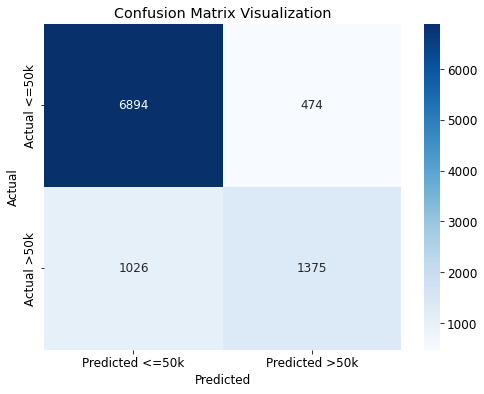

In [17]:
#=================================================-
#### Logistics Regression: Confusion matrix and accuracy  ####

# Take a look at test data confusion matrix.
conf_matrix_test = confusion_matrix(y_test, predicted_values)

# Visualize the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted <=50k', 'Predicted >50k'], yticklabels=['Actual <=50k', 'Actual >50k'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Visualization')
plt.show()

In [18]:
#=================================================-
#### Logistics Regression: Classification report  ####

# Create a list of target names to interpret class assignments.
target_names = ['<=50K', '>50K']

# Print an entire classification report.
class_report_log = metrics.classification_report(y_test,
                                            predicted_values,
                                            target_names = target_names)

print(class_report_log)

              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      7368
        >50K       0.74      0.57      0.65      2401

    accuracy                           0.85      9769
   macro avg       0.81      0.75      0.77      9769
weighted avg       0.84      0.85      0.84      9769



The performance indicators for the minority class in our model demonstrate the following characteristics:

- Precision (0.74): This high precision score implies that 74% of the model’s predictions for the minority class are accurate, indicating a low occurance of false positives.
- Recall (0.57): The recall rate is moderate, with the model correctly identifying 57% of actual cases within the minority class. This suggests a substantial number of false negatives.
- F1 Score (0.65): The F1 score, which combines precision and recall, is calculated at 0.65. It reflects a moderate accuracy level in the model’s ability to classify the minority class, highlighting its reliability in predictions but also its shortcomings in identifying a significant fraction of true cases.

These metrics reveal that while the model demonstrates fairly high precision, its ability to detect all relevant cases of the minority class is not as robust, leading to a moderate overall F1 score. There is potential for improvement, particularly in increasing recall without greatly affecting precision.

To improve our model’s ability to predict the minority class more accurately, we will employ SMOTE. This method will help rebalance our dataset and is anticipated to enhance the model's predictive metrics for the minority class.

In [19]:
#=================================================-
#### Balance target with SMOTE  ####

from imblearn.over_sampling import SMOTE

#Initialize SMOTE object.
smote = SMOTE()

#Fit the sampling method to our train data and classes.
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#Print previous and current target value counts
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_train_sm, return_counts=True)
print(dict(zip(unique, counts)))

{False: 17352, True: 5440}
{False: 17352, True: 17352}


We will now go through the model training process to evaluate whether the balancing of the dataset via SMOTE has enhanced the performance metrics. 

In [20]:
#=================================================-
#### Logistic regression: build  ####

# Set up logistic regression model.
logistic_regression_model_sm = linear_model.LogisticRegression(max_iter=1000, solver='lbfgs')
print(logistic_regression_model_sm)

LogisticRegression(max_iter=1000)


In [21]:
#=================================================-
#### Logistic regression: fit  ####

# Fit the model on the training data.
logistic_regression_model_sm.fit(X_train_sm,y_train_sm)

LogisticRegression(max_iter=1000)

In [22]:
#=================================================-
#### Logistics Regression: Accuracy on train vs accuracy on test  ####

# Compute trained model accuracy score.
test_accuracy_score_sm = logistic_regression_model_sm.score(X_test, y_test)
print("Accuracy on test data: " , test_accuracy_score_sm)

# Compute trained model accuracy score.
trained_accuracy_score_sm = logistic_regression_model_sm.score(X_train_sm, y_train_sm)
print("Accuracy on train data: " , trained_accuracy_score_sm)

Accuracy on test data:  0.7960896714095609
Accuracy on train data:  0.8304518211157216


In [23]:
#=================================================-
#### Logistic regression: predict  ####

# Predict on test data.
predicted_values_sm = logistic_regression_model_sm.predict(X_test)
print(predicted_values)

[False  True False ... False False  True]


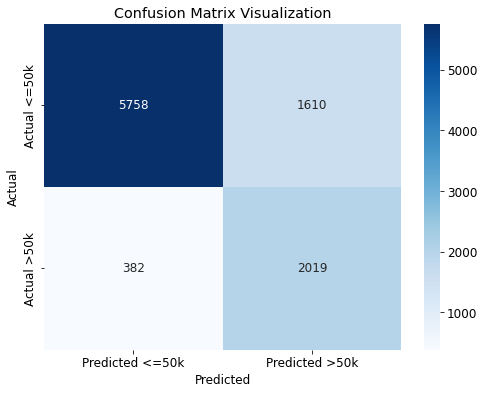

In [24]:
#=================================================-
#### Logistics Regression: Confusion matrix and accuracy  ####

# Take a look at test data confusion matrix.
conf_matrix_test_sm = confusion_matrix(y_test, predicted_values_sm)

# Visualize the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test_sm, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted <=50k', 'Predicted >50k'], yticklabels=['Actual <=50k', 'Actual >50k'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Visualization')
plt.show()

In [25]:
#=================================================-
#### Logistics Regression: Classification report  ####

# Create a list of target names to interpret label assignments.
target_names = ['<=50K', '>50K']

# Print an entire classification report.
class_report_log_sm = metrics.classification_report(y_test,
                                            predicted_values_sm,
                                            target_names = target_names)

print(class_report_log_sm)

              precision    recall  f1-score   support

       <=50K       0.94      0.78      0.85      7368
        >50K       0.56      0.84      0.67      2401

    accuracy                           0.80      9769
   macro avg       0.75      0.81      0.76      9769
weighted avg       0.84      0.80      0.81      9769



The application of Synthetic Minority Over-sampling Technique (SMOTE) on our dataset influenced the performance metrics of our minority class in distinct ways. Specifically, there was a decrement in precision, indicating an increase in false positives, while recall experienced an improvement, suggesting better identification of true positives within the minority class. Consequently, the F1 score, saw a marginal enhancement of 0.02. 

In terms of the majority class, removing the imbalance had a negative impact on both the precision and recall.

With all of that taken into condiseration, we are going to revert to using the imbalanced dataset due to its overall higher precision. This decision is important as the high cost of false positives in our context, developing policies to address income inequality and economic stability, could lead to misdirected resources and ineffective policy measures. Thus, ensuring high precision is essential to accurately inform and guide our policy recommendations.

We will now proceed to examine the Area Under the Curve (AUC) and the Receiver Operating Characteristic (ROC) curve to assess the strength of our decision threshold. This analysis will allow us to quantitatively evaluate the model's ability to choose between the positive and negative classes across a range of threshold values.

In [26]:
#=================================================-
#### Logistics Regression: Getting probabilities instead of class labels  ####

# Get probabilities instead of predicted values.
test_probabilities = logistic_regression_model.predict_proba(X_test)
print(test_probabilities[0:5, :])
# Get probabilities of test predictions only.
test_predictions = test_probabilities[:, 1]
print(test_predictions[0:5])

[[0.98398765 0.01601235]
 [0.16995244 0.83004756]
 [0.98867481 0.01132519]
 [0.4114954  0.5885046 ]
 [0.90193186 0.09806814]]
[0.01601235 0.83004756 0.01132519 0.5885046  0.09806814]


In [27]:
#=================================================-
#### Logistics Regression: Computing FPR, TPR, and threshold  ####

# Get FPR, TPR, and threshold values.
fpr, tpr, threshold = metrics.roc_curve(y_test,            #<- test data labels
                                        test_predictions)  #<- predicted probabilities
print("False positive: ", fpr[:5])
print("True positive: ", tpr[:5])
print("Threshold: ", threshold[:5])



False positive:  [0. 0. 0. 0. 0.]
True positive:  [0.         0.00041649 0.00374844 0.00458142 0.0062474 ]
Threshold:  [2. 1. 1. 1. 1.]


In [28]:
#=================================================-
#### Logistics Regressions: Computing AUC  ####

# Get AUC by providing the FPR and TPR.
auc = metrics.auc(fpr, tpr)
print("Area under the ROC curve: ", auc)



Area under the ROC curve:  0.9018486856951117


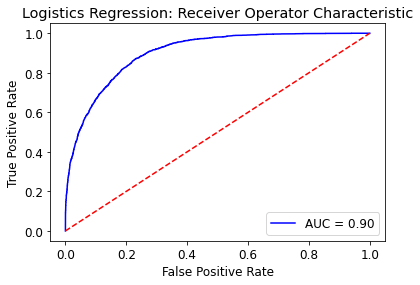

In [29]:
#=================================================-
#### Logistics Regression: ROC plot  ####

# Make an ROC curve plot.
plt.title('Logistics Regression: Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

An AUC of 0.9 indicates that the model has a high level of accuracy in recognizing the difference between the two classes. It means there is a 90% chance that the model will be able to distinguish between a randomly chosen positive instance and a randomly chosen negative instance.

Our current model exhibits strong performance metrics. However, to ensure that we have achieved the optimal solution, it is prudent to conduct a comparative analysis with alternative models. That being said, we will evaluate a Random Forest model and a Gradient Boosting model. The interpretation of the metrics and their evaluation will be systematically addressed in the 'Cumulative Results' section of our analysis. This section will provide a detailed statistical assessment of each model's performance, incorporating various metrics such as precision, recall, and AUC. 

### Modeling - Random Forest

In [30]:
#=================================================-
#### Random Forest: Building our model  ####

forest = RandomForestClassifier(criterion = 'gini',n_estimators = 100,random_state = 1)

In [31]:
#=================================================-
#### Random Forest: Fitting our model  ####

# Fit the saved model to your training data.
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [32]:
#=================================================-
#### Random Forest: Accuracy of the training and testing dataset ####

# Compute accuracy using training data.
acc_train_forest = forest.score(X_train, y_train)
print ("Train Accuracy:", acc_train_forest)

# Compute accuracy using training data.
acc_test_forest = forest.score(X_test, y_test)
print ("Test Accuracy:", acc_test_forest)

Train Accuracy: 0.9262899262899262
Test Accuracy: 0.8499334629951889


In [33]:
#=================================================-
#### Random Forest: Predicting with our data  ####

# Predict on test data.
y_predict_forest = forest.predict(X_test)

# Look at the first few predictions.
print(y_predict_forest[0:5,])

[False  True False  True False]


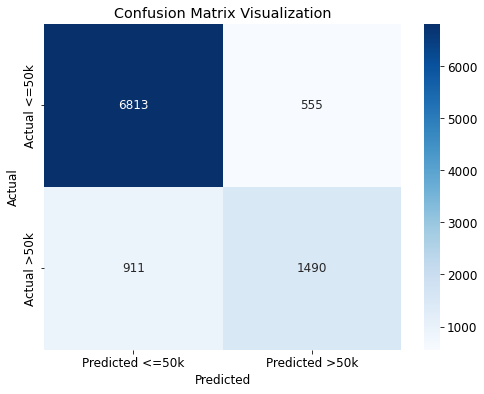

In [34]:
#=================================================-
#### Random Forest: Confusion matrix and accuracy  ####

# Take a look at test data confusion matrix.
conf_matrix_forest = metrics.confusion_matrix(y_test, y_predict_forest)

# Visualize the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_forest, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted <=50k', 'Predicted >50k'], yticklabels=['Actual <=50k', 'Actual >50k'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Visualization')
plt.show()

In [35]:
#=================================================-
#### Random Forest: Classification report ####

# Print an entire classification report.
class_report_forest = metrics.classification_report(y_test,
                                            y_predict_forest,
                                            target_names = target_names)

print(class_report_forest)

              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7368
        >50K       0.73      0.62      0.67      2401

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.84      0.85      0.85      9769



In [36]:
#=================================================-
#### Random Forest: Getting probabilities instead of class labels  ####

# Get probabilities instead of predicted values.
test_probabilities_forest = forest.predict_proba(X_test)
print(test_probabilities_forest[0:5, :])
# Get probabilities of test predictions only.
test_predictions_forest = test_probabilities_forest[:, 1]
print(test_predictions_forest[0:5])

[[0.92452381 0.07547619]
 [0.         1.        ]
 [1.         0.        ]
 [0.18309564 0.81690436]
 [1.         0.        ]]
[0.07547619 1.         0.         0.81690436 0.        ]


In [37]:
#=================================================-
#### Random Forest: Computing FPR, TPR, and threshold  ####

# Get FPR, TPR, and threshold values.
fpr_f, tpr_f, threshold_f = metrics.roc_curve(y_test,            #<- test data labels
                                        test_predictions_forest)  #<- predicted probabilities
print("False positive: ", fpr_f[:5])
print("True positive: ", tpr_f[:5])
print("Threshold: ", threshold_f[:5])

False positive:  [0.         0.00081433 0.00081433 0.00081433 0.00081433]
True positive:  [0.         0.12994586 0.13077884 0.13286131 0.13369429]
Threshold:  [2.         1.         0.998      0.9975     0.99727273]


In [38]:
#=================================================-
#### Random Forest: Computing AUC  ####

# Get AUC by providing the FPR and TPR.
auc_f = metrics.auc(fpr_f, tpr_f)
print("Area under the ROC curve: ", auc_f)

Area under the ROC curve:  0.8938919033012395


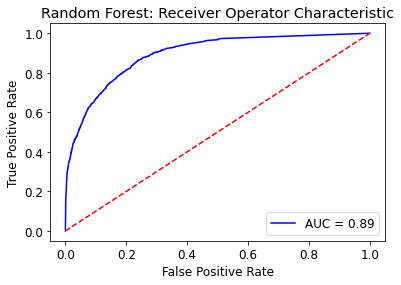

In [39]:
#=================================================-
#### Random Forest: ROC plot  ####

# Make an ROC curve plot.
plt.title('Random Forest: Receiver Operator Characteristic')
plt.plot(fpr_f, tpr_f, 'b', label = 'AUC = %0.2f' % auc_f)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Text(0.5, 0, 'Relative Importance')

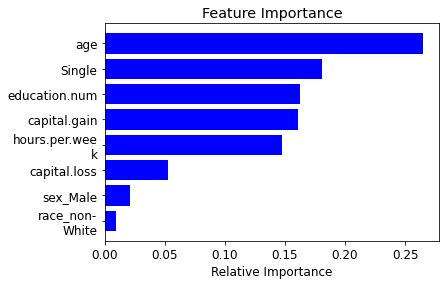

In [40]:
#=================================================-
#### Random Forest: Subsetting our features  ####

#census_features = X.drop('income', axis = 1)
features = X.columns
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[0:10][::-1]

plt.figure(1)
plt.title('Feature Importance')
plt.barh(range(len(top_indices)), importances[top_indices], color = 'b', align = 'center')
labels = features[top_indices]
labels = [ '\n'.join(wrap(l,13)) for l in labels ]
plt.yticks(range(len(top_indices)), labels)
plt.xlabel('Relative Importance')

Looking at the feature importance, all features under consideration exhibit some influence on model performance. With that said, we will retain all features in our model to preserve the integrity of the predictive accuracy. 

### Modeling - Gradient Boosting

In [41]:
#=================================================-
#### Boosting: build model  ####

# Save the parameters we will be using for our gradient boosting classifier.
gbm = GradientBoostingClassifier(n_estimators = 200,learning_rate = 1,max_depth = 2,random_state = 1)

In [42]:
#=================================================-
#### Boosting: fit model  ####

# Fit the saved model to your training data.
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, max_depth=2, n_estimators=200,
                           random_state=1)

In [43]:
#=================================================-
#### Boosting: Accuracy of training and testing models  ####

# Compute accuracy using training data.
train_accuracy_gbm = gbm.score(X_train, y_train)
print ("Train Accuracy:", train_accuracy_gbm)

test_accuracy_gbm = gbm.score(X_test, y_test)
print ("Test Accuracy:", test_accuracy_gbm)

Train Accuracy: 0.8702614952614952
Test Accuracy: 0.8705087521752483


In [44]:
#=================================================-
#### Boosting: predict  ####

# Predict on test data.
predicted_values_gbm = gbm.predict(X_test)
print(predicted_values_gbm)

[False  True False ... False False  True]


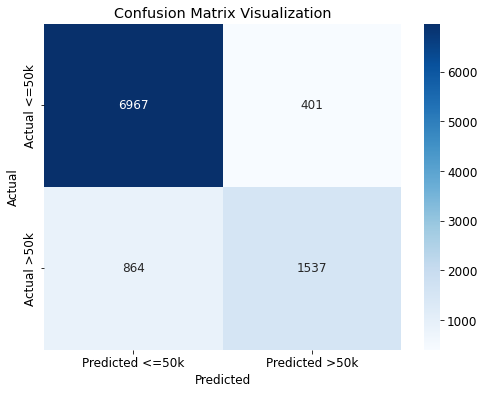

In [45]:
#=================================================-
#### Boosting: Confusion matrix and accuracy  ####

# Take a look at test data confusion matrix.
conf_matrix_boosting = metrics.confusion_matrix(y_test, predicted_values_gbm)

# Visualize the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_boosting, annot=True, fmt="d", cmap='Blues', xticklabels=['Predicted <=50k', 'Predicted >50k'], yticklabels=['Actual <=50k', 'Actual >50k'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix Visualization')
plt.show()

In [46]:
#=================================================-
#### Boosting: Classification report  ####

# Create a list of target names to interpret class assignments.
target_names = ['<=50K', '>50K']

# Print an entire classification report.
class_report_gmb = metrics.classification_report(y_test,
                                            predicted_values_gbm,
                                            target_names = target_names)

print(class_report_gmb)

              precision    recall  f1-score   support

       <=50K       0.89      0.95      0.92      7368
        >50K       0.79      0.64      0.71      2401

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769



In [47]:
#=================================================-
#### Boosting: Getting probabilities instead of class labels  ####

# Get probabilities instead of predicted values.
test_probabilities_gbm = gbm.predict_proba(X_test)
print(test_probabilities_gbm[0:5, :])

# Get probabilities of test predictions only.
test_predictions_gbm = test_probabilities_gbm[:, 1]
print(test_predictions_gbm[0:5])

[[9.93932149e-01 6.06785064e-03]
 [3.86475856e-02 9.61352414e-01]
 [9.99282732e-01 7.17268304e-04]
 [3.28680982e-01 6.71319018e-01]
 [9.78788029e-01 2.12119710e-02]]
[6.06785064e-03 9.61352414e-01 7.17268304e-04 6.71319018e-01
 2.12119710e-02]


In [48]:
#=================================================-
#### Boosting: Computing FPR, TPR, and threshold  ####

# Get FPR, TPR, and threshold values.
fpr_gbm, tpr_gbm, threshold_gbm = metrics.roc_curve(y_test,            #<- test data labels
                                        test_predictions_gbm)  #<- predicted probabilities
print("False positive: ", fpr_gbm[:5])
print("True positive: ", tpr_gbm[:5])
print("Threshold: ", threshold_gbm[:5])

False positive:  [0. 0. 0. 0. 0.]
True positive:  [0.         0.00041649 0.02832153 0.02915452 0.05414411]
Threshold:  [1.99999151 0.99999151 0.99982873 0.99982563 0.9996356 ]


In [49]:
#=================================================-
#### Boosting: Computing AUC  ####

# Get AUC by providing the FPR and TPR.
auc_gbm = metrics.auc(fpr_gbm, tpr_gbm)
print("Area under the ROC curve: ", auc_gbm)

Area under the ROC curve:  0.9270211674379252


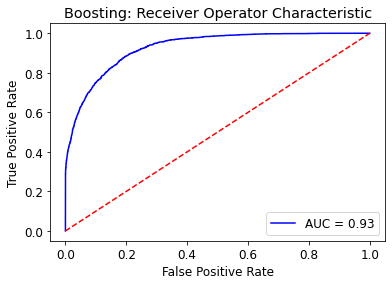

In [50]:
#=================================================-
#### Boosting: ROC plot  ####

# Make an ROC curve plot.
plt.title('Boosting: Receiver Operator Characteristic')
plt.plot(fpr_gbm, tpr_gbm, 'b', label = 'AUC = %0.2f' % auc_gbm)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Text(0.5, 0, 'Relative Importance')

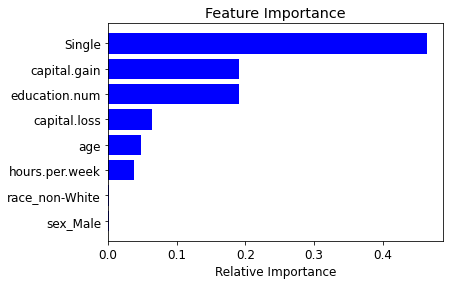

In [51]:
#=================================================-
#### Boosting: Top features  ####

features = X.columns
importances = gbm.feature_importances_
indices = np.argsort(importances)[::-1]
top_indices = indices[0:10][::-1]

plt.figure(1)
plt.title('Feature Importance')
plt.barh(range(len(top_indices)), importances[top_indices], color = 'b', align = 'center')
labels = features[top_indices]
labels = [ '\n'.join(wrap(l,13)) for l in labels ]
plt.yticks(range(len(top_indices)), features[top_indices])
plt.xlabel('Relative Importance')

Looking at the list of feature importance, the features 'race_non-White' and 'sex_Male' appear to minimally impact our Gradient Boosting model. An experimental iteration (Not shown here) was conducted where these features were excluded, and the model was subsequently re-evaluated. The analysis of the adjusted model did not demonstrate a significant improvement in performance. Therefore, for the sake of maintaining consistency across comparative analyses with our other models, we will retain these features in the Gradient Boosting model configuration.

### Cumulative Results 

In [52]:
#=================================================-
#### Compare all Model Metrics  ####
print("Logistic Regression Model: ")
print(class_report_log)
print()

print("Random Forest Classifier: ")
print(class_report_forest)
print()

print("Gradient Boosting: ")
print(class_report_gmb)
print()

Logistic Regression Model: 
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      7368
        >50K       0.74      0.57      0.65      2401

    accuracy                           0.85      9769
   macro avg       0.81      0.75      0.77      9769
weighted avg       0.84      0.85      0.84      9769


Random Forest Classifier: 
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7368
        >50K       0.73      0.62      0.67      2401

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.84      0.85      0.85      9769


Gradient Boosting: 
              precision    recall  f1-score   support

       <=50K       0.89      0.95      0.92      7368
        >50K       0.79      0.64      0.71      2401

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      97

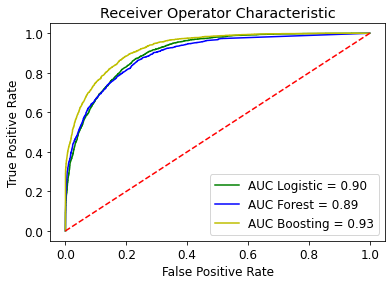

In [53]:
#=================================================-
#### ROC plot  ####

# Make an ROC curve plot.
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'g', label = 'AUC Logistic = %0.2f' % auc)
plt.plot(fpr_f, tpr_f, 'b', label = 'AUC Forest = %0.2f' % auc_f)
plt.plot(fpr_gbm, tpr_gbm, 'y', label = 'AUC Boosting = %0.2f' % auc_gbm)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In the logistic regression section of our analysis, we decided to focus on precision and F1-score as the primary metrics for evaluating model performance, rather than accuracy. That decision was based on the presence of imbalance in our dataset and our objective to minimize false positives. Accuracy can be misleading in imbalanced contexts as it can primarily reflect the majority class's prevalence. By contrast, precision provides a direct measure of our model's ability to avoid false positives, while the F1-score offers a balanced measure that considers both the precision and the recall, making it particularly useful in situations where class distribution is uneven. 

Considering the evaluation metrics tailored to our dataset, characteristics, and analysis goals, all models demonstrated solid performance. However, our assessment revealed that the Gradient Boosting model outperformed both the logistic regression model and the Random Forest classifier across all key metrics. This better performance is quantitatively significant, which suggests that the Gradient Boosting model is more effective at handling the particular challenges of our imbalanced data. The enhanced capability of the Gradient Boosting model to generalize and accurately predict across differing scenarios is supported by its higher precision, better F1-score, and improved recall. 

### Conclusions

This comparative analysis of different machine learning models using census data supports the potential of predictive analytics in understanding individual income levels. By effectively employing models such as Gradient Boosting, which has shown superior performance in our evaluations, we can derive deeper insights into the factors influencing income disparities. The findings from this study are particularly valuable for policymakers and economists who are dedicated to addressing issues of income inequality and economic stability. Through the enhanced predictive power of our chosen models, we can provide actionable intelligence that supports the development of targeted interventions and informed policy decisions. 